In [1]:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# install required libraries
- most libraries already shipped in anaconda 

In [4]:
#! pip install catboost

# Data acqusition
- Please download the only CSV files from CIC-IDS-2018 dataset as shown in our paper "CatBoost-based network intrusion detection on imbalanced CIC-IDS-2018 dataset"
- store it in corresponding folder. In my case it is `/data/juma/data/net_intrusion/cic-ids-2018/original/`

## Explorative data analysis (EDA)
we would like to answer following questions on CIC-IDS-2018
- class distribution 
- distribution of the features
    - nan values for each feature. Exclude mostly nan features
    - their variance. exclude low variance features

In [1]:
import pandas as pd
from os.path import join
from glob import glob
import ntpath
from tqdm import tqdm
from collections import defaultdict

dataroot = '/data/juma/data/net_intrusion/cic-ids-2018/original/'
pdataroot = '/data/juma/data/net_intrusion/cic-ids-2018/preprocessed/' 


## pre-processing
- filter out bad rows
- filter out unnecassary columns
- to workaraound memory error I am reducing the datasize to 10% of original size

In [2]:
# note, specifying dtype reduces loading speed of dataframe
DTYPES = {'Dst Port':str, 'Protocol':str, 'Timestamp':str, 'Flow Duration':float, 'Tot Fwd Pkts':int,
       'Tot Bwd Pkts':int, 'TotLen Fwd Pkts':int, 'TotLen Bwd Pkts':int, 'Fwd Pkt Len Max':int,
       'Fwd Pkt Len Min':int, 'Fwd Pkt Len Mean':float, 'Fwd Pkt Len Std':float,
       'Bwd Pkt Len Max':int, 'Bwd Pkt Len Min':int, 'Bwd Pkt Len Mean':float,
       'Bwd Pkt Len Std':float, 'Flow Byts/s':float, 'Flow Pkts/s':float, 'Flow IAT Mean':float,
       'Flow IAT Std':float, 'Flow IAT Max':int, 'Flow IAT Min':int, 'Fwd IAT Tot':int,
       'Fwd IAT Mean':float, 'Fwd IAT Std':float, 'Fwd IAT Max':int, 'Fwd IAT Min':int,
       'Bwd IAT Tot':int, 'Bwd IAT Mean':float, 'Bwd IAT Std':float, 'Bwd IAT Max':int,
       'Bwd IAT Min':int, 'Fwd PSH Flags':int, 'Bwd PSH Flags':int, 'Fwd URG Flags':int,
       'Bwd URG Flags':int, 'Fwd Header Len':int, 'Bwd Header Len':int, 'Fwd Pkts/s':float,
       'Bwd Pkts/s':float, 'Pkt Len Min':int, 'Pkt Len Max':int, 'Pkt Len Mean':float,
       'Pkt Len Std':float, 'Pkt Len Var':float, 'FIN Flag Cnt':int, 'SYN Flag Cnt':int,
       'RST Flag Cnt':int, 'PSH Flag Cnt':int, 'ACK Flag Cnt':int, 'URG Flag Cnt':int,
       'CWE Flag Count':int, 'ECE Flag Cnt':int, 'Down/Up Ratio':float, 'Pkt Size Avg':float,
       'Fwd Seg Size Avg':float, 'Bwd Seg Size Avg':float, 'Fwd Byts/b Avg':float,
       'Fwd Pkts/b Avg':float, 'Fwd Blk Rate Avg':float, 'Bwd Byts/b Avg':float,
       'Bwd Pkts/b Avg':float, 'Bwd Blk Rate Avg':float, 'Subflow Fwd Pkts':int,
       'Subflow Fwd Byts':int, 'Subflow Bwd Pkts':int, 'Subflow Bwd Byts':int,
       'Init Fwd Win Byts':int, 'Init Bwd Win Byts':int, 'Fwd Act Data Pkts':int,
       'Fwd Seg Size Min':int, 'Active Mean':float, 'Active Std':float, 'Active Max':int,
       'Active Min':int, 'Idle Mean':float, 'Idle Std':float, 'Idle Max':int, 'Idle Min':int, 'Label':str}

### Filter out rows with erroneous records 

In [ ]:
# file_paths = [fn for fn in glob(join(dataroot,'*.csv'))]

# for fn in tqdm(file_paths):    
#     df = pd.read_csv(fn, low_memory=False)
#     df = df.sort_values(['Label'])
#     N = df.shape[0]
#     df = df.iloc[(-2*N)//10:,:] # removing first 90% of the rows which contain mostly Benign
#     if 'Flow ID' in df.columns:
#         df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP'],axis=1, inplace=True)
    
#     filtered_df = df[df['Flow Duration']!='Flow Duration']
#     print(ntpath.basename(fn), df.shape[0]-filtered_df.shape[0], 'rows removed')

#     filtered_df.drop(['Timestamp'],axis=1).to_csv(fn.replace('original','preprocessed'), index=False)

### class distribution

In [3]:
label_dist = defaultdict(lambda: 0)

for fn in tqdm(glob(join(pdataroot,'*.csv'))):
    for lbl, cnt in pd.read_csv(fn, usecols=['Label'], dtype=DTYPES).Label.value_counts().items():
        label_dist[lbl]+=cnt        

df = pd.DataFrame({'categories':label_dist.keys(),'counts':label_dist.values()})
outfile = 'class_distribution.png'

100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


In [4]:
df

,categories,counts
0,Bot,209715
1,DDOS attack-HOIC,207985
2,DDOS attack-LOIC-UDP,1730
3,Infilteration,135071
4,Benign,1642995
5,Brute Force -Web,611
6,Brute Force -XSS,230
7,SQL Injection,87
8,SSH-Bruteforce,187589
9,FTP-BruteForce,22126


#### Lets plot the same thing in R, cuz it is fancier 

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R 
library (tibble)
library(dplyr)
library(forcats)
library(tidyr)
library(purrr)
library(psych)
library(stringr)
library(ggplot2)
library(ggsci) 
library(ggpubr)

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='Arial'
) +
theme(
    axis.title.x=element_text(colour="grey20",size=13,angle=0,hjust=.5,vjust=.5, face="bold"),
    axis.title.y=element_text(colour="grey20",size=13,angle=90,hjust=.5,vjust=1, face="bold"),
    axis.text.x=element_text(colour="grey20",size=11,angle=0,hjust=.5,vjust=.5),
    axis.text.y=element_text(colour="grey20",size=11,angle=0,hjust=.5,vjust=.5),
    strip.text.x=element_text(colour="grey20",size=13,angle=0,hjust=0.5,vjust=.25, face="bold"),
    strip.text.y=element_text(colour="grey20",size=13,angle=270,hjust=.5,vjust=.5, face="bold"),
#     legend.title=element_text(colour="grey20",size=13,angle=0,hjust=0.5,vjust=.5,face="bold"),
#     legend.position='top'
)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘ggplot2’


R[write to console]: The following objects are masked from ‘package:psych’:

    %+%, alpha




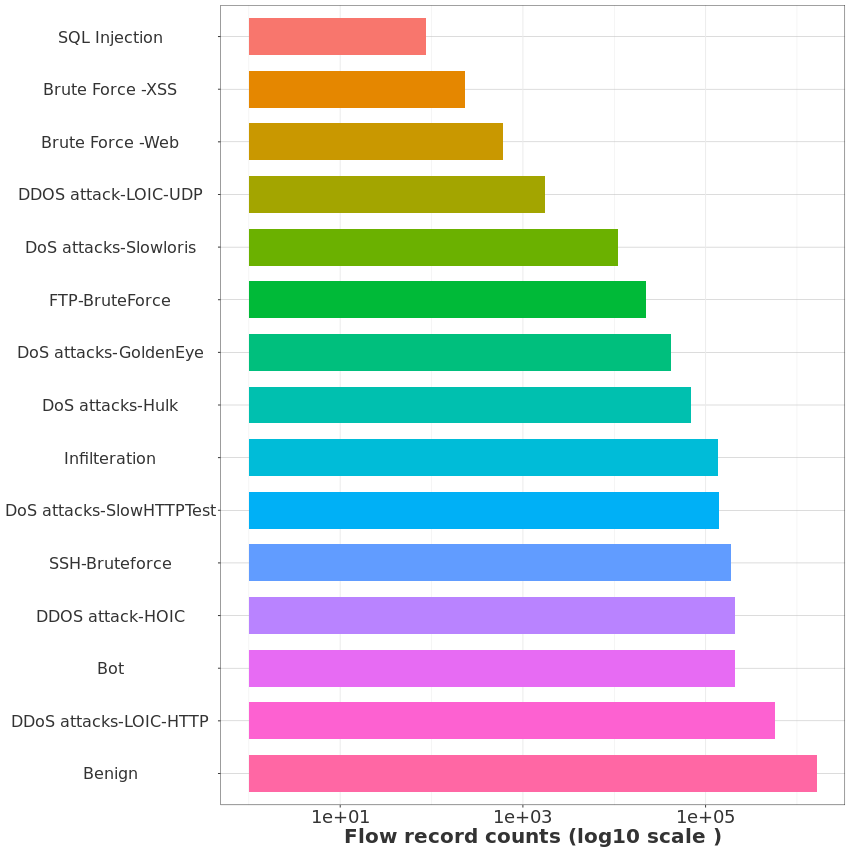

In [10]:
%%R -i df -w 30 -h 30 -u cm -i outfile

p <- ggplot(df,aes(fill=reorder(categories,counts),y=counts,x=reorder(categories,-counts)))+
    geom_bar(position="dodge", stat="identity", width=0.7)+
    coord_flip()+
    labs(
            y='Flow record counts (log10 scale )'
        ) + 
    scale_y_log10()+
        THEME_DEFAULT+
        theme(            
            panel.grid.major.y = element_line(size=0.25, linetype='solid', color='grey'),
            panel.grid.minor.y = element_line(size=0.01, linetype='solid', color='grey'),
            axis.text.x = element_text(size=18,margin = margin(r = 10)),
            axis.text.y = element_text(size=16),
            axis.title.x = element_text(size=20),
            axis.title.y = element_blank(),
            strip.text.y = element_text(size=20),
            legend.position="none"
        )
print(p)
ggsave(outfile, p, width=30, height=30, units='cm', dpi=500)

# ML experiment

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
RANDOM_STATE = 42

X = pd.concat([pd.read_csv(fn, dtype=DTYPES).drop(['Label'],axis=1) for fn in tqdm(glob(join(pdataroot,'*.csv')))])
y = pd.concat([pd.read_csv(fn, dtype=DTYPES, usecols=['Label']) for fn in tqdm(glob(join(pdataroot,'*.csv')))])
feature_names = X.columns.to_list()

### Handle Non-number and missing values

In [ ]:
import numpy as np
cat_features = ['Dst Port','Protocol']
X.replace([np.inf, -np.inf], np.nan, inplace=True)
for c in tqdm(X.columns):
    if c in cat_features:
        continue
    X[c].fillna((X[c].mean()), inplace=True)

### encode categoricals


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder().fit(X[cat_features])
X_enc = X.copy(deep=True)
res = enc.transform(X[cat_features])
X_enc['Dst Port'] = res[:,0]
X_enc['Protocol'] = res[:,1]

### Data Split

In [ ]:
from sklearn.model_selection import StratifiedKFold,  StratifiedShuffleSplit
skf =  StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in skf.split(X, y):
    print(train_index.shape[0]/test_index.shape[0])


## Experiment I: Imbalanced setting 

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt.fit(X_enc.iloc[train_index], y.iloc[train_index])


pred = dt.predict(X_enc.iloc[test_index])
bal_acc = balanced_accuracy_score(y.iloc[test_index], pred)
acc = accuracy_score(y.iloc[test_index], pred)
bal_acc, acc

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_enc.iloc[train_index], y.iloc[train_index])

pred = rf.predict(X_enc.iloc[test_index])
accuracy_score(y.iloc[test_index], pred), balanced_accuracy_score(y.iloc[test_index], pred)

### CatBoost

In [ ]:
import catboost
cb_clf = catboost.CatBoostClassifier(
           task_type = "GPU")

skf =  StratifiedShuffleSplit(n_splits=1, test_size=.2)
for dev_index, val_index in skf.split(X.iloc[train_index], y.iloc[train_index]):
    pass
dev_index.shape[0]/val_index.shape[0]
    
    
d_dev = catboost.Pool(
    data = X.iloc[train_index].iloc[dev_index],
    label = y.iloc[train_index].iloc[dev_index],
    feature_names = feature_names,
    cat_features = cat_features
)

d_val = catboost.Pool(
    data = X.iloc[train_index].iloc[val_index],
    label = y.iloc[train_index].iloc[val_index],
    feature_names = feature_names,
    cat_features = cat_features
)
cb_clf.fit(X = d_dev,
          use_best_model=True,
           eval_set = d_val,
           verbose_eval=False,
           early_stopping_rounds=20,
           plot=True
          )

pred = cb_clf.predict(X.iloc[test_index])
balanced_accuracy_score(y.iloc[test_index], pred), accuracy_score(y.iloc[test_index], pred)


## Experiment II: Balanced setting

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = ros.fit_resample(X_enc.iloc[train_index], y.iloc[train_index])

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt.fit(X_train_resampled, y_train_resampled)


pred = dt.predict(X_enc.iloc[test_index])
bal_acc = balanced_accuracy_score(y.iloc[test_index], pred)
acc = accuracy_score(y.iloc[test_index], pred)
bal_acc, acc

### Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf.fit(X_train_resampled, y_train_resampled)

pred = rf.predict(X_enc.iloc[test_index])
accuracy_score(y.iloc[test_index], pred), balanced_accuracy_score(y.iloc[test_index], pred)

### CatBoost

In [ ]:
import catboost
cb_clf = catboost.CatBoostClassifier(
           task_type = "GPU"
)


X_train_resampled, y_train_resampled = ros.fit_resample(X.iloc[train_index], y.iloc[train_index])
skf =  StratifiedShuffleSplit(n_splits=1, test_size=.2)
for dev_index, val_index in skf.split(X_train_resampled, y_train_resampled):
    pass   
d_dev = catboost.Pool(
    data = X_train_resampled.iloc[dev_index],
    label = y_train_resampled.iloc[dev_index],
    feature_names = feature_names,
    cat_features = cat_features
)
d_val = catboost.Pool(
    data = X_train_resampled.iloc[val_index],
    label = y_train_resampled.iloc[val_index],
    feature_names = feature_names,
    cat_features = cat_features
)

cb_clf.fit(X = d_dev,
          use_best_model=True,
           eval_set = d_val,
           verbose_eval=False,
           early_stopping_rounds=20,
           plot=True
          )
catboost_ref_clf = cb_clf
pred = cb_clf.predict(X.iloc[test_index])
balanced_accuracy_score(y.iloc[test_index], pred), accuracy_score(y.iloc[test_index], pred)


#### seperate balancing for dev and val

In [ ]:
import catboost
cb_clf = catboost.CatBoostClassifier(
           task_type = "GPU")


skf =  StratifiedShuffleSplit(n_splits=1, test_size=.2)
for dev_index, val_index in skf.split(X.iloc[train_index], y.iloc[train_index]):
    pass   

X_dev_balanced, y_dev_balanced = ros.fit_resample(X.iloc[train_index].iloc[dev_index], y.iloc[train_index].iloc[dev_index])
d_dev = catboost.Pool(
    data = X_dev_balanced,
    label = y_dev_balanced,
    feature_names = feature_names,
    cat_features = cat_features
)

X_val_balanced, y_val_balanced = ros.fit_resample(X.iloc[train_index].iloc[val_index], y.iloc[train_index].iloc[val_index])
d_val = catboost.Pool(
    data = X_val_balanced,
    label = y_val_balanced,
    feature_names = feature_names,
    cat_features = cat_features
)

cb_clf.fit(X = d_dev,
          use_best_model=True,
           eval_set = d_val,
           verbose_eval=False,
           early_stopping_rounds=20,
           plot=True
          )

pred = cb_clf.predict(X.iloc[test_index])
balanced_accuracy_score(y.iloc[test_index], pred), accuracy_score(y.iloc[test_index], pred)


## Feature Selection

In [ ]:
def regress(alg: str,
            X: pd.DataFrame,
            y: np.ndarray,
            cat_features: Iterable[str] = None,
            params: Dict[str, any] = None,
            random_state: int = None):
    if alg.lower() == 'lasso':
        cls = LassoCV
    elif alg.lower() == 'elastic':
        cls = ElasticNetCV
    else:
        raise ValueError('"alg" should be one of "lasso" or "elastic"')

    cv = StratifiedKFold(shuffle=False if random_state is None else True, random_state=random_state)
    params_ = dict() if params is None else params
    classifier = cls(cv=cv, **params_)
    M_cat = X.columns.isin([] if cat_features is None else cat_features)
    I_num, I_cat = np.flatnonzero(~M_cat), np.flatnonzero(M_cat)
    X_num = StandardScaler().fit_transform(X.iloc[:, I_num])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        classifier.fit(X=X_num, y=y)

    betas = np.concatenate((classifier.coef_, np.repeat(np.inf, len(I_cat))))
    I = np.argsort(np.concatenate((I_num, I_cat), axis=0))

    return {k: v for k, v in zip(X.columns, betas[I])}